# Imports

In [1]:
# Data
from data                   import commodities, nutrients
# Importing libraries
from random                 import shuffle, choice, sample, random, uniform
from copy                   import deepcopy
from operator               import attrgetter
import matplotlib.pyplot    as plt
import numpy                as np
import pandas               as pd
# Importing classes and functions
from individual             import Individual
from population             import Population
from selection              import roulette, ranked, tournament
from variation              import crossover, mutation
from algorithm              import genetic_algorithm, get_fitness

# Functions

In [21]:
def evaluation(population_size, evolve_parameters, iterations=30):
    history = {}
    items_combined = []
    products = []
    for i in range(iterations):
        # Monkey Patching
        Individual.get_fitness = get_fitness
        # create initial population
        pop = Population(size=population_size, optim="min", sol_size=len(commodities), valid_set=list(range(2)), replacement=True)
        # evolve
        pop.evolve(
            select = evolve_parameters['select'],
            tournament_k = evolve_parameters['tournament_k'],
            gens = evolve_parameters['gens'], 
            mut_prob = evolve_parameters['mut_prob'],
            mutate = evolve_parameters['mutate'],
            mut_type = evolve_parameters['mut_type'],
            mut_cycles = evolve_parameters['mut_cycles'],
            bit_flips = evolve_parameters['bit_flips'],
            xo_prob = evolve_parameters['xo_prob'],
            crossover = evolve_parameters['crossover'],
            xo_type = evolve_parameters['xo_type'],
            elitism = evolve_parameters['elitism']
        )
        
        history[i] = pop.history_fitness
        items_combined += pop.history_products
        products.append(pop.history_products)

    product_count = {i:items_combined.count(i) for i in set(items_combined)}

    min_individual = np.argmin(np.array(list(history.values()))[:,-1])
    table = {}
    for i in products[min_individual]:
        table[i] = commodities[i][0]
    table['SUM'] = round(sum(table.values()),4)
    
    return history, product_count, table

def plot_results(results, product_count, table):
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(nrows=2, ncols=2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    # fitness history lineplot
    for i in results.keys():
        ax1.plot(list(results.values())[i-1], label=f'Run {i}')
    ax1.plot(np.mean(list(results.values()), axis=0), color='black', label='Mean', linestyle='--', linewidth=4)
    ax1.set_title('Fitness History')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness ($)')
    ax1.legend(ncol=2, fontsize=8, loc='upper right')

    # product count barplot
    product_count_sorted = {k: v for k, v in sorted(product_count.items(), key=lambda item: item[1])[-10:]}
    bars = ax2.barh(list(product_count_sorted.keys()), list(product_count_sorted.values()))
    ax2.bar_label(bars, labels=list(product_count_sorted.keys()), label_type='center', fontsize=8)
    ax2.set_yticklabels([])
    ax2.set_title('Most Common Optimal Products (Top 10)')
    ax2.set_xlabel('Count')

    # best solution table
    df = pd.DataFrame(table, index=['Price ($)']).T.reset_index().rename(columns={'index':'Product'})
    cols = [["w","w"] for i in range(len(df))]
    cols[-1] = ["#C5C7C5","#C5C7C5"]
    ax3.table(cellText=df.values,colLabels=df.columns,rowLabels=df.index,loc='center',cellLoc='center', cellColours=cols)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_title('Best Solution')

    plt.show()

# 1st Run
|Parameter                 | Value             |
|--------------------------|-------------------|
|Generations per Iterarion:| 30                |
|Population Size:          | 500               |               
|Selection:                | Roulette          |
|Mutation:                 | Single-Bit-Flip   |
|Crossover:                | One-Point         |
|Elitism:                  | True              |

In [16]:
evolve_parameters = {
    "select": roulette,
    "tournament_k": None,
    "gens": 30,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_bit_flip",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "one-point",
    "elitism": True
    }

results, product_count, table = evaluation(population_size=500, evolve_parameters=evolve_parameters)

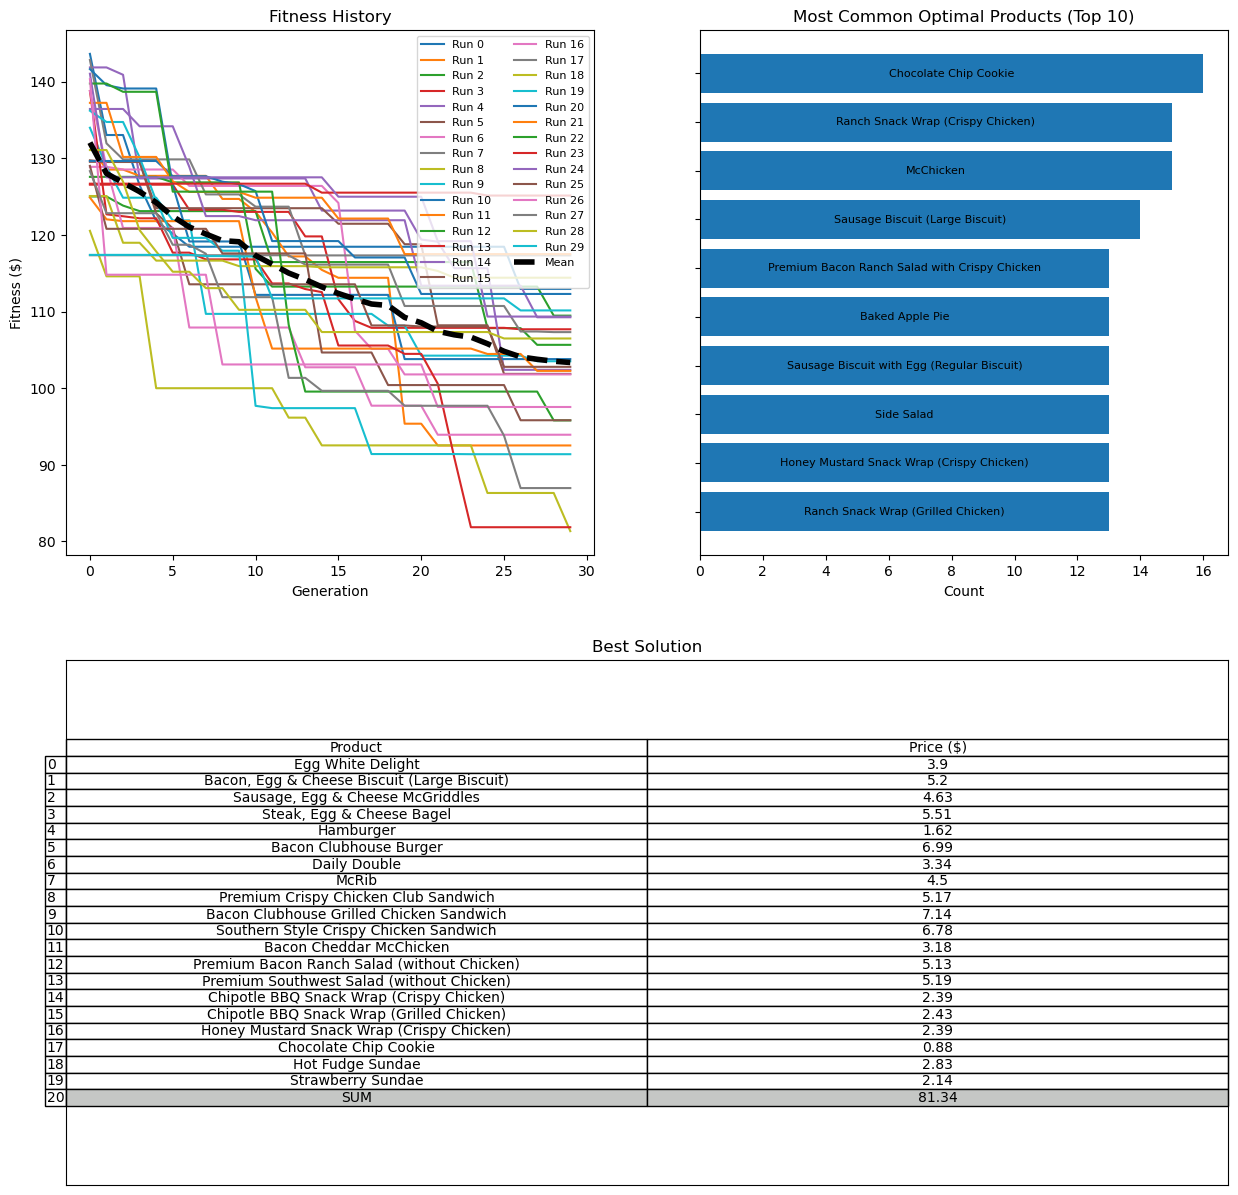

In [22]:
plot_results(results, product_count, table)

**Conclusion**

- Algorithm decreases slowly
- No convergence reached

# 2nd Run

|Parameter                 | Value             |
|--------------------------|-------------------|
|Generations per Iterarion:| 100               |
|Population Size:          | 500               |               
|Selection:                | Roulette          |
|Mutation:                 | Single-Bit-Flip   |
|Crossover:                | One-Point         |
|Elitism:                  | True              |

In [26]:
evolve_parameters = {
    "select": roulette,
    "tournament_k": None,
    "gens": 100,
    "mut_prob": 0.2,
    "mutate": mutation,
    "mut_type": "single_bit_flip",
    "mut_cycles": None,
    "bit_flips": None,
    "xo_prob": 0.9,
    "crossover": crossover,
    "xo_type": "one-point",
    "elitism": True
    }

results, product_count, table = evaluation(population_size=500, evolve_parameters=evolve_parameters)

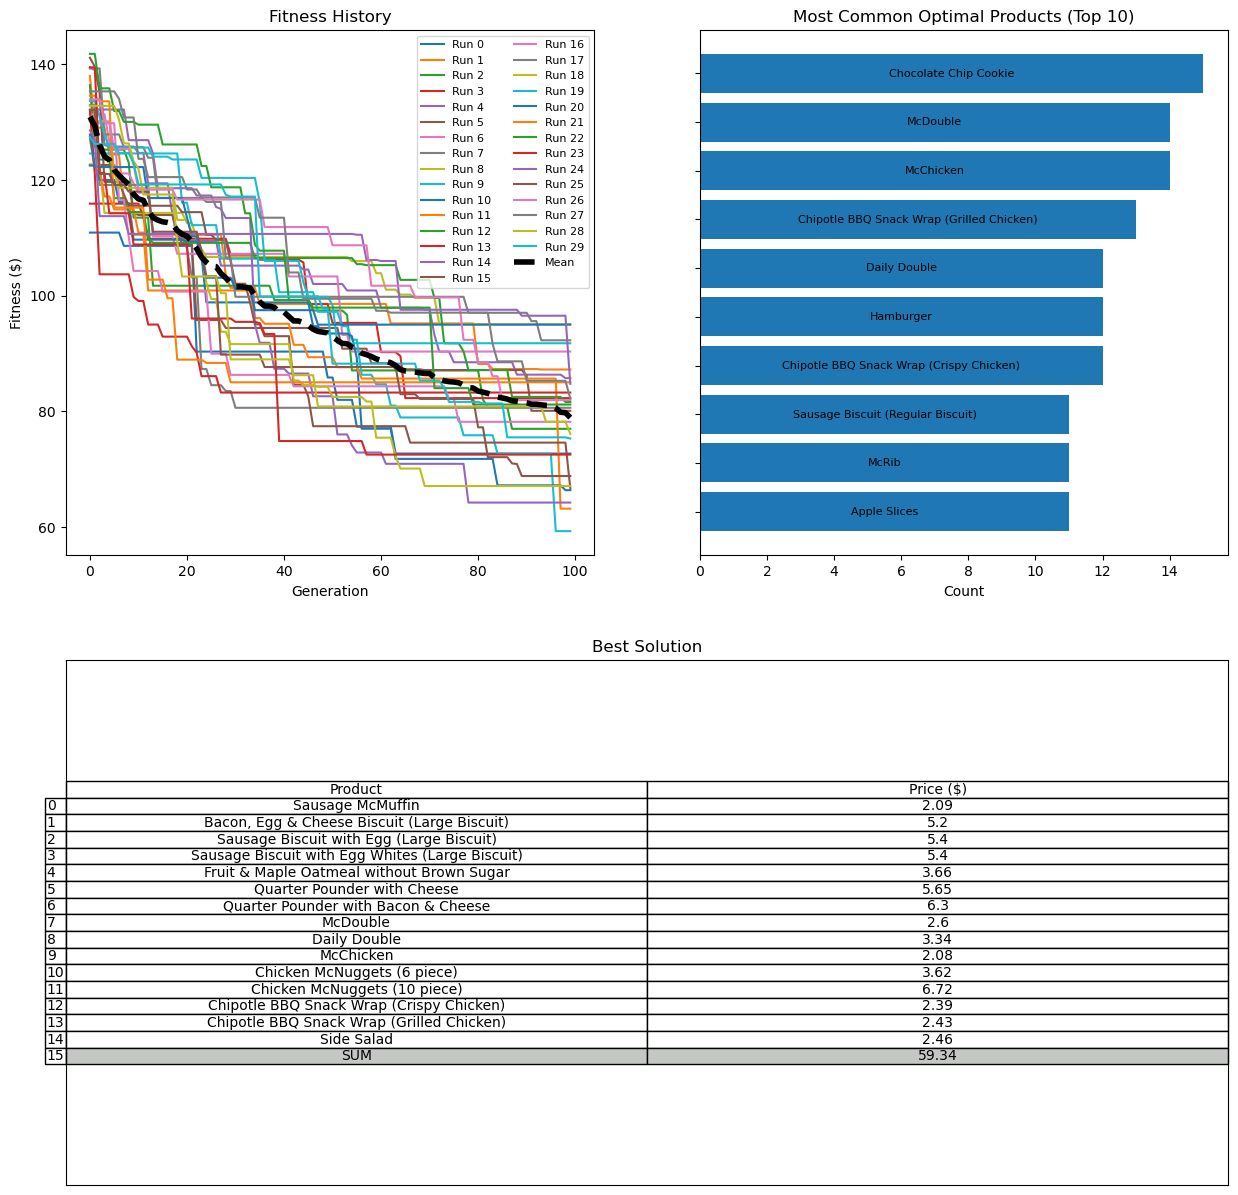

In [27]:
plot_results(results, product_count, table)